In [2]:
import os
os.chdir(r"D:\Abhinav Tar Files\Snapshots")

Snapshot   1 | Inertia b/a=0.990, c/a=0.915 | Hull b/a=0.957, c/a=0.889
Snapshot   2 | Inertia b/a=0.990, c/a=0.916 | Hull b/a=0.957, c/a=0.889
Snapshot   3 | Inertia b/a=0.990, c/a=0.916 | Hull b/a=0.966, c/a=0.890
Snapshot   4 | Inertia b/a=0.990, c/a=0.916 | Hull b/a=0.966, c/a=0.890
Snapshot   5 | Inertia b/a=0.990, c/a=0.916 | Hull b/a=0.966, c/a=0.890
Snapshot   6 | Inertia b/a=0.990, c/a=0.917 | Hull b/a=0.966, c/a=0.890
Snapshot   7 | Inertia b/a=0.990, c/a=0.917 | Hull b/a=0.966, c/a=0.890
Snapshot   8 | Inertia b/a=0.990, c/a=0.917 | Hull b/a=0.966, c/a=0.890
Snapshot   9 | Inertia b/a=0.990, c/a=0.917 | Hull b/a=0.966, c/a=0.890
Snapshot  10 | Inertia b/a=0.990, c/a=0.918 | Hull b/a=0.966, c/a=0.890
Snapshot  11 | Inertia b/a=0.990, c/a=0.918 | Hull b/a=0.971, c/a=0.889
Snapshot  12 | Inertia b/a=0.990, c/a=0.918 | Hull b/a=0.971, c/a=0.889
Snapshot  13 | Inertia b/a=0.990, c/a=0.918 | Hull b/a=0.971, c/a=0.889
Snapshot  14 | Inertia b/a=0.990, c/a=0.919 | Hull b/a=0.971, c/

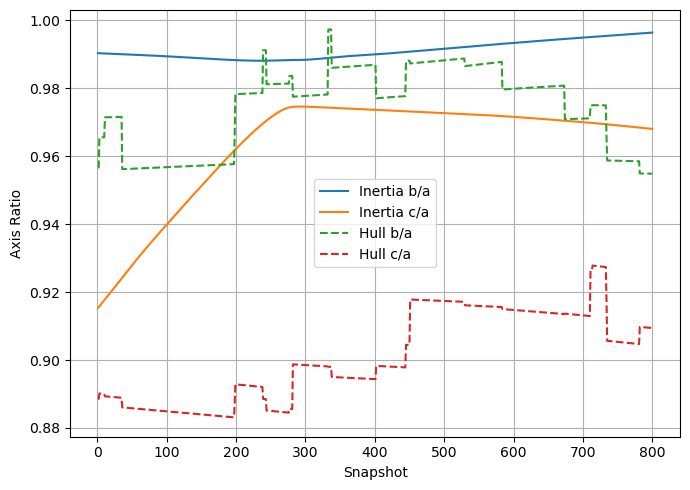

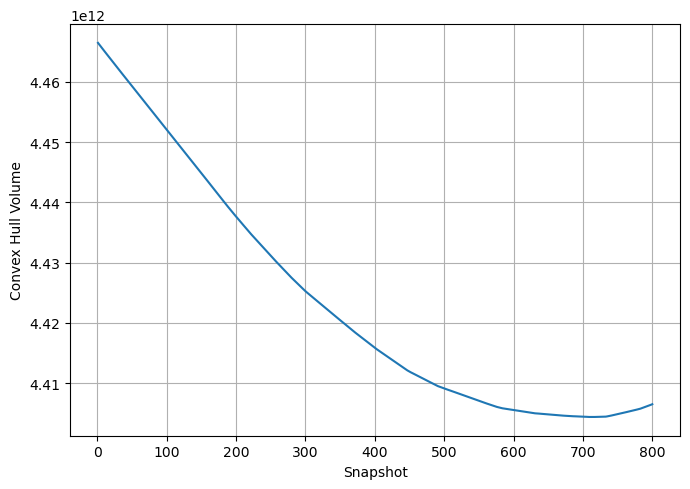

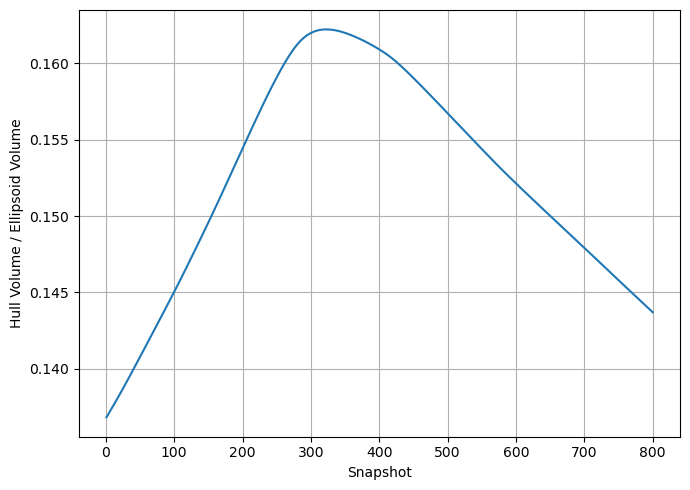

In [4]:
"""
MW–M31 Halo Shape Evolution
Standard Inertia Tensor + Convex Hull Geometry

This script computes:
1. Mass-weighted inertia-tensor axis ratios (standard practice)
2. Purely geometric convex-hull axis ratios
3. Convex-hull volume
4. Ellipsoidal volume from inertia axes
5. Volume inflation factor (geometric irregularity indicator)

Designed for merger snapshots of the MW–M31 system.
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from CenterOfMass2 import CenterOfMass


# ------------------------------------------------------------
# Inertia tensor–based shape (standard practice)
# ------------------------------------------------------------

def compute_inertia_tensor(positions, masses):
    """
    Compute the unreduced inertia tensor:
        I_ij = sum_k m_k (r_k^2 δ_ij - x_{k,i} x_{k,j})
    """
    r2 = np.sum(positions**2, axis=1)
    I = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            delta = 1.0 if i == j else 0.0
            I[i, j] = np.sum(masses * (r2 * delta - positions[:, i] * positions[:, j]))
    return I


def inertia_axis_ratios(I):
    """
    Return (b/a, c/a) from inertia tensor eigenvalues.
    """
    eigvals = np.sort(np.linalg.eigvalsh(I))[::-1]
    b_over_a = np.sqrt(eigvals[1] / eigvals[0])
    c_over_a = np.sqrt(eigvals[2] / eigvals[0])
    return b_over_a, c_over_a, eigvals


# ------------------------------------------------------------
# Convex hull–based geometric shape (novel method)
# ------------------------------------------------------------

def convex_hull_properties(positions):
    """
    Compute convex hull volume and principal axis ratios.

    Axis ratios are computed from the covariance of hull vertices,
    not from particle masses.
    """
    hull = ConvexHull(positions)
    verts = positions[hull.vertices]

    # Covariance of hull geometry
    cov = np.cov(verts.T)
    eigvals = np.sort(np.linalg.eigvalsh(cov))[::-1]

    b_over_a = np.sqrt(eigvals[1] / eigvals[0])
    c_over_a = np.sqrt(eigvals[2] / eigvals[0])

    return hull.volume, b_over_a, c_over_a


def ellipsoid_volume_from_inertia(eigvals):
    """
    Construct an equivalent ellipsoid volume from inertia eigenvalues.
    Used only for comparison, not as a physical halo model.
    """
    a = np.sqrt(eigvals[0])
    b = np.sqrt(eigvals[1])
    c = np.sqrt(eigvals[2])
    return (4.0 / 3.0) * np.pi * a * b * c


# ------------------------------------------------------------
# Snapshot loop
# ------------------------------------------------------------

snaps = np.arange(1, 801)  # 801 snapshots

# Inertia-based time series
ba_inertia = np.zeros(len(snaps))
ca_inertia = np.zeros(len(snaps))

# Convex-hull–based time series
ba_hull = np.zeros(len(snaps))
ca_hull = np.zeros(len(snaps))
hull_volume = np.zeros(len(snaps))
volume_inflation = np.zeros(len(snaps))


for i, s in enumerate(snaps):

    mw_file = f"MW_{s:03d}.txt"
    m31_file = f"M31_{s:03d}.txt"

    MW = CenterOfMass(mw_file, 1)
    M31 = CenterOfMass(m31_file, 1)

    # Combine particle data
    x = np.concatenate((MW.x, M31.x))
    y = np.concatenate((MW.y, M31.y))
    z = np.concatenate((MW.z, M31.z))
    m = np.concatenate((MW.m, M31.m))
    pos = np.vstack((x, y, z)).T

    # Center on MW center of mass
    xcom, ycom, zcom = MW.COMdefine(x, y, z, m)
    pos -= np.array([xcom, ycom, zcom])

    # --- Inertia tensor shape ---
    I = compute_inertia_tensor(pos, m)
    bI, cI, eigvals = inertia_axis_ratios(I)

    ba_inertia[i] = bI
    ca_inertia[i] = cI

    # --- Convex hull shape ---
    Vh, bH, cH = convex_hull_properties(pos)
    ba_hull[i] = bH
    ca_hull[i] = cH
    hull_volume[i] = Vh

    # --- Volume comparison ---
    Vell = ellipsoid_volume_from_inertia(eigvals)
    volume_inflation[i] = Vh / Vell

    print(f"Snapshot {s:3d} | Inertia b/a={bI:.3f}, c/a={cI:.3f} | "
          f"Hull b/a={bH:.3f}, c/a={cH:.3f}")


# ------------------------------------------------------------
# Plots
# ------------------------------------------------------------

# Axis ratios
plt.figure(figsize=(7, 5))
plt.plot(snaps, ba_inertia, label="Inertia b/a")
plt.plot(snaps, ca_inertia, label="Inertia c/a")
plt.plot(snaps, ba_hull, "--", label="Hull b/a")
plt.plot(snaps, ca_hull, "--", label="Hull c/a")
plt.xlabel("Snapshot")
plt.ylabel("Axis Ratio")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("halo_axis_ratio_comparison.png", dpi=300)

# Hull volume
plt.figure(figsize=(7, 5))
plt.plot(snaps, hull_volume)
plt.xlabel("Snapshot")
plt.ylabel("Convex Hull Volume")
plt.grid()
plt.tight_layout()
plt.savefig("halo_hull_volume.png", dpi=300)

# Volume inflation factor
plt.figure(figsize=(7, 5))
plt.plot(snaps, volume_inflation)
plt.xlabel("Snapshot")
plt.ylabel("Hull Volume / Ellipsoid Volume")
plt.grid()
plt.tight_layout()
plt.savefig("halo_volume_inflation.png", dpi=300)

plt.show()

Processed 1/802 snapshots (s=0)
Processed 2/802 snapshots (s=1)
Processed 3/802 snapshots (s=2)
Processed 4/802 snapshots (s=3)
Processed 5/802 snapshots (s=4)
Processed 6/802 snapshots (s=5)
Processed 7/802 snapshots (s=6)
Processed 8/802 snapshots (s=7)
Processed 9/802 snapshots (s=8)
Processed 10/802 snapshots (s=9)
Processed 11/802 snapshots (s=10)
Processed 12/802 snapshots (s=11)
Processed 13/802 snapshots (s=12)
Processed 14/802 snapshots (s=13)
Processed 15/802 snapshots (s=14)
Processed 16/802 snapshots (s=15)
Processed 17/802 snapshots (s=16)
Processed 18/802 snapshots (s=17)
Processed 19/802 snapshots (s=18)
Processed 20/802 snapshots (s=19)
Processed 21/802 snapshots (s=20)
Processed 22/802 snapshots (s=21)
Processed 23/802 snapshots (s=22)
Processed 24/802 snapshots (s=23)
Processed 25/802 snapshots (s=24)
Processed 26/802 snapshots (s=25)
Processed 27/802 snapshots (s=26)
Processed 28/802 snapshots (s=27)
Processed 29/802 snapshots (s=28)
Processed 30/802 snapshots (s=29)

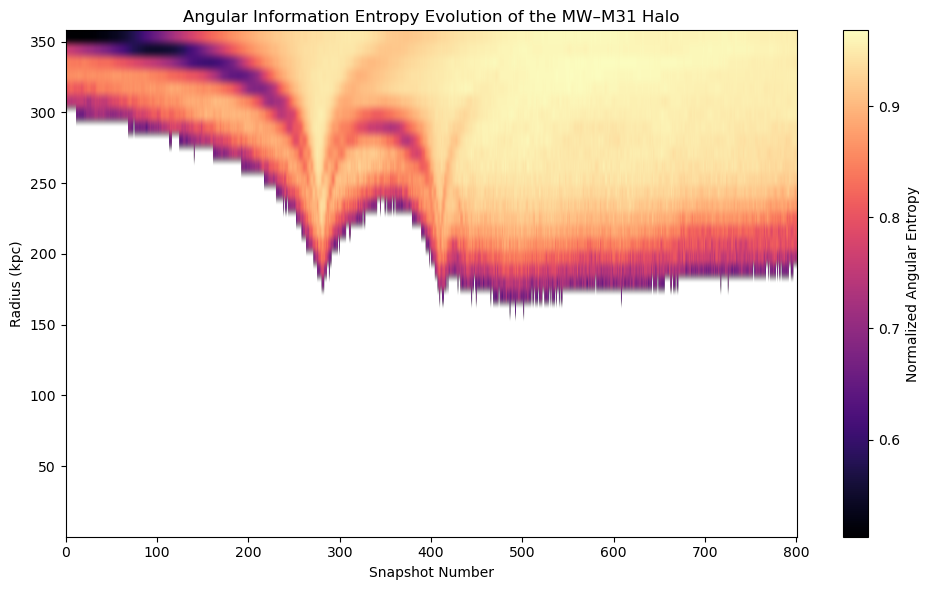

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from CenterOfMass2 import CenterOfMass
import warnings

warnings.filterwarnings("ignore")

# ============================================================
# CONFIGURATION
# ============================================================

# Snapshot range
start_snap = 0
end_snap = 801
snaps = np.arange(start_snap, end_snap + 1)
nsnaps = len(snaps)

# Radial binning (logarithmic to resolve inner halo and outskirts)
r_bins = np.logspace(-1, 2.6, 40)
r_mid = np.sqrt(r_bins[:-1] * r_bins[1:])
nbins = len(r_mid)

# Angular discretization
# Chosen to balance angular resolution and particle noise
n_theta = 12   # polar bins
n_phi = 24     # azimuthal bins
n_ang_bins = n_theta * n_phi

# Storage for angular entropy as a function of time and radius
angular_entropy = np.full((nsnaps, nbins), np.nan)

# ============================================================
# HELPER FUNCTIONS
# ============================================================

def spherical_angles(pos):
    """
    Convert Cartesian positions into spherical coordinates.

    Parameters
    ----------
    pos : (N,3) array
        Particle positions in a centered reference frame.

    Returns
    -------
    r : array
        Radial distances.
    theta : array
        Polar angles in [0, pi].
    phi : array
        Azimuthal angles in [0, 2pi).

    Notes
    -----
    Only angular information is used in the entropy calculation;
    the radial coordinate is used exclusively for shell selection.
    """
    r = np.linalg.norm(pos, axis=1)
    theta = np.arccos(np.clip(pos[:,2] / r, -1, 1))
    phi = np.mod(np.arctan2(pos[:,1], pos[:,0]), 2*np.pi)
    return r, theta, phi


def angular_entropy_shell(theta, phi, masses):
    """
    Compute the normalized angular information entropy
    of the mass distribution on a spherical shell.

    Parameters
    ----------
    theta, phi : arrays
        Angular coordinates of particles in the shell.
    masses : array
        Particle masses.

    Returns
    -------
    S_norm : float
        Shannon entropy normalized to the maximum possible value.

    Physical Meaning
    ----------------
    - S_norm ~ 1 : isotropic angular distribution
    - S_norm < 1 : anisotropy, substructure, or tidal features

    This statistic is independent of radius and total mass
    and does not assume ellipsoidal symmetry.
    """
    theta_bins = np.linspace(0, np.pi, n_theta + 1)
    phi_bins = np.linspace(0, 2*np.pi, n_phi + 1)

    # Mass-weighted angular histogram
    hist = np.zeros((n_theta, n_phi))

    theta_idx = np.digitize(theta, theta_bins) - 1
    phi_idx = np.digitize(phi, phi_bins) - 1

    valid = (
        (theta_idx >= 0) & (theta_idx < n_theta) &
        (phi_idx >= 0) & (phi_idx < n_phi)
    )

    for t, p, m in zip(theta_idx[valid], phi_idx[valid], masses[valid]):
        hist[t, p] += m

    total_mass = np.sum(hist)
    if total_mass == 0:
        return np.nan

    # Probability distribution over angular bins
    prob = hist.flatten() / total_mass
    prob = prob[prob > 0]

    # Shannon entropy
    S = -np.sum(prob * np.log(prob))
    S_max = np.log(n_ang_bins)

    return S / S_max


# ============================================================
# MAIN ANALYSIS LOOP
# ============================================================

processed = 0

for i, s in enumerate(snaps):
    mw_file = f"MW_{s:03d}.txt"
    m31_file = f"M31_{s:03d}.txt"

    # Load particle data
    try:
        MW = CenterOfMass(mw_file, 1)
        M31 = CenterOfMass(m31_file, 1)
        processed += 1
        print(f"Processed {processed}/{nsnaps} snapshots (s={s})")
    except Exception:
        continue

    # Combine MW and M31 particles into a single system
    x = np.concatenate((MW.x, M31.x))
    y = np.concatenate((MW.y, M31.y))
    z = np.concatenate((MW.z, M31.z))
    m = np.concatenate((MW.m, M31.m))
    pos = np.vstack((x, y, z)).T

    # Recenter using the MW center of mass
    # This removes bulk motion while preserving merger asymmetries
    xcom, ycom, zcom = MW.COMdefine(x, y, z, m)
    pos -= np.array([xcom, ycom, zcom])

    # Convert to spherical coordinates
    r, theta, phi = spherical_angles(pos)

    # Compute angular entropy in each radial shell
    for b in range(nbins):
        shell = (r >= r_bins[b]) & (r < r_bins[b+1])

        # Require sufficient sampling to suppress shot noise
        if np.sum(shell) < 50:
            continue

        angular_entropy[i, b] = angular_entropy_shell(
            theta[shell], phi[shell], m[shell]
        )

# ============================================================
# VISUALIZATION
# ============================================================

plt.figure(figsize=(10, 6))

im = plt.imshow(
    angular_entropy.T,
    origin="lower",
    aspect="auto",
    extent=[snaps[0], snaps[-1], r_mid[0], r_mid[-1]],
    cmap="magma"
)

plt.colorbar(im, label="Normalized Angular Entropy")
plt.ylabel("Radius (kpc)")
plt.xlabel("Snapshot Number")
plt.title("Angular Information Entropy Evolution of the MW–M31 Halo")

plt.tight_layout()
plt.savefig("angular_entropy_halo_evolution.png", dpi=300)
plt.show()